### Import packages

In [3]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import cal_mape

from utilities import cal_score, convert_types, create_dt_feats

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Params

In [4]:
is_log_target = True
is_per_area_target = True

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [5]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    return df  #, cols_feats

In [6]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)
    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)

        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)


In [7]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [97]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [9]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df.head(5)

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696


### Preprocessing

In [10]:
df = pre_processing(df, cols_num, cols_cat)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [98]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

In [99]:
# PARS #
N_feats_rm = 68
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],
                         'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

print('N feats (before):', len(cols_feats))
cols_feats = list(set(cols_feats) - set(feats_rm))
print('N feats (after):', len(cols_feats))
print(cols_feats)

[[0 'XIII_index_500' 5524.196631427719 1.6666614648256655]
 [1 'VI_500' 5524.196588360582 1.6666183976885804]
 [2 'IX_index_50' 5523.863284797632 1.3333148347392125]
 [3 'I_50' 5523.529966556772 0.9999965938786772]
 [4 'III_index_50' 5523.52993208159 0.9999621186971126]
 [5 'XIV_100' 5523.529795207054 0.999825244161002]
 [6 'X_50' 5523.196637563681 0.6666676007880596]
 [7 'VI_index_500' 5523.196626105514 0.6666561426209228]
 [8 'VIII_index_50' 5523.19662525478 0.6666552918868547]
 [9 'XI_index_1000' 5523.196624752728 0.6666547898348654]
 [10 'XIII_250' 5523.196536159863 0.6665661969700523]
 [11 'N_500' 5523.196516711289 0.6665467483962857]
 [12 'XIII_index_50' 5522.863304462509 0.33333449961628503]
 [13 'I_index_1000' 5522.863304129733 0.3333341668394496]
 [14 'I_10' 5522.8633036210485 0.33333365815542493]
 [15 'IV_index_1000' 5522.863299346049 0.3333293831556148]
 [16 'VIII_index_1000' 5522.863298332599 0.3333283697056686]
 [17 'IX_index_1000' 5522.863297587239 0.33332762434565666]
 [

### Grid search

In [13]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.01,
             }

lgb_other_params = {'num_boost_round': 50000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000 }

# prvs baseline best estimator
# ('objective', 'mse'), ('metric', 'mape'),
# ('learning_rate', 0.015), ('num_leaves', 255),
# ('feature_fraction', 0.5), ('min_data_in_leaf', 5),
# ('lambda_l1', 0.1), ('lambda_l2', 0.1)),
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

#params_gsearch = {'max_depth':[-1, 8],
#                  'num_leaves': [200, 255]}

params_gsearch = {'max_depth': [22, 24, 26, 30],
                  'num_leaves': [255, 270, 280, 290, 300, 310, 320],
                  'feature_fraction': [0.4, 0.45, 0.5, 0.5],
                  'min_data_in_leaf': list(range(5, 11, 1)),
                  'lambda_l1': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1],
                  'lambda_l2': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1],
                  'max_bin': [255, 255, 383, 511, 1023],
                  'min_sum_hessian_in_leaf': [0.1, 0.01, 0.001, 0.001, 0.0001],
                  'min_data_per_group': [100, 100, 75, 50, 25, 10, 5],
                 }


N_fold = 3
N_iter = 21
score_low_bound = 5300 # if score smaller than this, skip the param set

#### Round 1

In [14]:
# Round 1
rand_params_set = [{
    'max_depth': 24,
    'num_leaves': 300,
    'feature_fraction': 0.5,
    'min_data_in_leaf': 10,
    'lambda_l1': 0.1,
    'lambda_l2': 0.0,
    'max_bin': 255,
    'min_sum_hessian_in_leaf': 0.001,
    'min_data_per_group': 100,
}]
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [15]:
rand_params_set

[{'max_depth': 24,
  'num_leaves': 300,
  'feature_fraction': 0.5,
  'min_data_in_leaf': 10,
  'lambda_l1': 0.1,
  'lambda_l2': 0.0,
  'max_bin': 255,
  'min_sum_hessian_in_leaf': 0.001,
  'min_data_per_group': 100},
 {'max_depth': 26,
  'num_leaves': 320,
  'feature_fraction': 0.45,
  'min_data_in_leaf': 8,
  'lambda_l1': 0.05,
  'lambda_l2': 0.06,
  'max_bin': 255,
  'min_sum_hessian_in_leaf': 0.01,
  'min_data_per_group': 100},
 {'max_depth': 26,
  'num_leaves': 300,
  'feature_fraction': 0.4,
  'min_data_in_leaf': 9,
  'lambda_l1': 0.02,
  'lambda_l2': 0.0,
  'max_bin': 383,
  'min_sum_hessian_in_leaf': 0.001,
  'min_data_per_group': 5},
 {'max_depth': 26,
  'num_leaves': 280,
  'feature_fraction': 0.4,
  'min_data_in_leaf': 8,
  'lambda_l1': 0.06,
  'lambda_l2': 0.08,
  'max_bin': 511,
  'min_sum_hessian_in_leaf': 0.01,
  'min_data_per_group': 100},
 {'max_depth': 22,
  'num_leaves': 290,
  'feature_fraction': 0.5,
  'min_data_in_leaf': 6,
  'lambda_l1': 0.08,
  'lambda_l2': 0.07,

In [16]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()
        
    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        tp0 = time.time()
        params = params_fix.copy()
        params.update( params_rand )

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, keep_training_booster=True,
                          **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])
        mse = mean_squared_error(df_val[col_target], y_pred)
        mae = mean_absolute_error(df_val[col_target], y_pred)
        mape = cal_mape(df_val[col_target], y_pred)
        
        y_pred_final = post_processing(y_pred, df_val)
        score = cal_score(df_val['total_price'], y_pred_final)

        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (score, mse, mae, mape), 
              ' - Time spent:', time.time() - tp0)
        print()
        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(model.best_iteration)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
# [0. params, 1. mean score, 2. mean mse, 3. mean mae, 4. mean mape, 5. iters, 
#  6. scores list, 7. mse list, 8. mae list, 9. mape list]
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00969546
[4000]	valid_0's mape: 0.00951545
[6000]	valid_0's mape: 0.00946903
[8000]	valid_0's mape: 0.00945193
[10000]	valid_0's mape: 0.00944483
[12000]	valid_0's mape: 0.00944125
[14000]	valid_0's mape: 0.00943955
Early stopping, best iteration is:
[13720]	valid_0's mape: 0.00943955
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.1, 'lambda_l2': 0.0, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.001, 'min_data_per_group': 100}
score, mse, mae, mape: 5736.86925, 0.03852, 0.12552, 0.00944.  - Time spent: 320.93918108940125

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00967674
[4000]	valid_0's mape: 0.00950574
[6000]	valid_0's mape: 0.0094635
[8000]	valid_0's mape: 0.00944875
[1

[2000]	valid_0's mape: 0.0097323
[4000]	valid_0's mape: 0.00952751
[6000]	valid_0's mape: 0.00947183
[8000]	valid_0's mape: 0.00945134
[10000]	valid_0's mape: 0.00944112
[12000]	valid_0's mape: 0.00943539
[14000]	valid_0's mape: 0.0094327
[16000]	valid_0's mape: 0.00943173
[18000]	valid_0's mape: 0.00943085
[20000]	valid_0's mape: 0.00943013
[22000]	valid_0's mape: 0.0094296
[24000]	valid_0's mape: 0.00942907
[26000]	valid_0's mape: 0.00942869
[28000]	valid_0's mape: 0.00942838
[30000]	valid_0's mape: 0.00942817
[32000]	valid_0's mape: 0.00942797
[34000]	valid_0's mape: 0.00942782
[36000]	valid_0's mape: 0.00942765
[38000]	valid_0's mape: 0.00942754
[40000]	valid_0's mape: 0.00942745
[42000]	valid_0's mape: 0.00942738
[44000]	valid_0's mape: 0.00942732
[46000]	valid_0's mape: 0.00942726
[48000]	valid_0's mape: 0.00942722
[50000]	valid_0's mape: 0.00942718
Did not meet early stopping. Best iteration is:
[49999]	valid_0's mape: 0.00942718
params: {'task': 'train', 'boosting_type': 'gbdt'

params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 22, 'num_leaves': 290, 'feature_fraction': 0.5, 'min_data_in_leaf': 6, 'lambda_l1': 0.05, 'lambda_l2': 0.0, 'max_bin': 511, 'min_sum_hessian_in_leaf': 0.001, 'min_data_per_group': 25}
score, mse, mae, mape: 5762.86932, 0.03857, 0.12540, 0.00943.  - Time spent: 395.590989112854

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00968572
[4000]	valid_0's mape: 0.00951687
[6000]	valid_0's mape: 0.00947198
[8000]	valid_0's mape: 0.00945697
[10000]	valid_0's mape: 0.00945082
[12000]	valid_0's mape: 0.00944756
[14000]	valid_0's mape: 0.00944566
Early stopping, best iteration is:
[14393]	valid_0's mape: 0.0094455
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 320, 'feature_fraction': 0.45, 'min_data_in_leaf': 10, 'lambda_l1': 0.07, 'lamb

Early stopping, best iteration is:
[15430]	valid_0's mape: 0.0094603
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 30, 'num_leaves': 280, 'feature_fraction': 0.5, 'min_data_in_leaf': 6, 'lambda_l1': 0.08, 'lambda_l2': 0.02, 'max_bin': 1023, 'min_sum_hessian_in_leaf': 0.01, 'min_data_per_group': 75}
score, mse, mae, mape: 5763.87062, 0.03988, 0.12600, 0.00945.  - Time spent: 346.50893807411194

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00979008
[4000]	valid_0's mape: 0.00958882
[6000]	valid_0's mape: 0.00953043
[8000]	valid_0's mape: 0.00950682
[10000]	valid_0's mape: 0.0094958
[12000]	valid_0's mape: 0.00949021
[14000]	valid_0's mape: 0.00948631
[16000]	valid_0's mape: 0.00948391
[18000]	valid_0's mape: 0.0094823
[20000]	valid_0's mape: 0.00948128
[22000]	valid_0's mape: 0.00948047
[24000]	valid_0's mape: 0.00947988
[26000]	valid_0's mape: 0.00947941
[28000]	val

[2000]	valid_0's mape: 0.00971253
[4000]	valid_0's mape: 0.00955776
[6000]	valid_0's mape: 0.00951575
[8000]	valid_0's mape: 0.00949921
[10000]	valid_0's mape: 0.00949139
[12000]	valid_0's mape: 0.00948716
[14000]	valid_0's mape: 0.00948519
Early stopping, best iteration is:
[14271]	valid_0's mape: 0.00948513
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 30, 'num_leaves': 320, 'feature_fraction': 0.5, 'min_data_in_leaf': 6, 'lambda_l1': 0.07, 'lambda_l2': 0.02, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.001, 'min_data_per_group': 5}
score, mse, mae, mape: 5760.87034, 0.04016, 0.12629, 0.00947.  - Time spent: 352.51632285118103

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00973847
[4000]	valid_0's mape: 0.00956512
[6000]	valid_0's mape: 0.00951585
[8000]	valid_0's mape: 0.00949607
[10000]	valid_0's mape: 0.00948541
[12000]	valid_0's mape: 0.00947987
[14000]	valid

[8000]	valid_0's mape: 0.00954747
[10000]	valid_0's mape: 0.00953577
[12000]	valid_0's mape: 0.00952979
[14000]	valid_0's mape: 0.00952646
[16000]	valid_0's mape: 0.00952463
[18000]	valid_0's mape: 0.00952406
Early stopping, best iteration is:
[17170]	valid_0's mape: 0.00952406
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 26, 'num_leaves': 280, 'feature_fraction': 0.4, 'min_data_in_leaf': 8, 'lambda_l1': 0.06, 'lambda_l2': 0.08, 'max_bin': 511, 'min_sum_hessian_in_leaf': 0.01, 'min_data_per_group': 100}
score, mse, mae, mape: 5740.86729, 0.04021, 0.12659, 0.00952.  - Time spent: 335.9220201969147

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00979271
[4000]	valid_0's mape: 0.00961009
[6000]	valid_0's mape: 0.00955968
[8000]	valid_0's mape: 0.00953787
[10000]	valid_0's mape: 0.00952747
[12000]	valid_0's mape: 0.00952216
[14000]	valid_0's mape: 0.00951887
Early stop

[2000]	valid_0's mape: 0.00980256
[4000]	valid_0's mape: 0.00960652
[6000]	valid_0's mape: 0.00955592
[8000]	valid_0's mape: 0.00953463
[10000]	valid_0's mape: 0.00952454
[12000]	valid_0's mape: 0.00951895
[14000]	valid_0's mape: 0.00951569
Early stopping, best iteration is:
[14380]	valid_0's mape: 0.00951542
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 22, 'num_leaves': 280, 'feature_fraction': 0.45, 'min_data_in_leaf': 10, 'lambda_l1': 0.1, 'lambda_l2': 0.08, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.01, 'min_data_per_group': 100}
score, mse, mae, mape: 5744.86721, 0.03998, 0.12650, 0.00951.  - Time spent: 302.6697402000427

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00977931
[4000]	valid_0's mape: 0.00960764
[6000]	valid_0's mape: 0.00956476
[8000]	valid_0's mape: 0.00954698
[10000]	valid_0's mape: 0.00953764
[12000]	valid_0's mape: 0.00953266
[14000]	vali

In [17]:
print('Total computing time:', t1-t0)

Total computing time: 28885.55781698227


In [32]:
for i, row in enumerate(gsearch_results):
    print(i, *row)

0 (('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 30), ('num_leaves', 320), ('feature_fraction', 0.45), ('min_data_in_leaf', 5), ('lambda_l1', 0.05), ('lambda_l2', 0.0), ('max_bin', 383), ('min_sum_hessian_in_leaf', 0.0001), ('min_data_per_group', 100)) 5771.535771219314 0.03974566857252212 0.12602316216067558 0.009469200681311027 [16016, 15941, 15710] [5806.869398253862, 5770.8707262746075, 5736.867189129471] [0.03858288770428787, 0.040280957772050444, 0.04037316024122802] [0.12526509381564746, 0.12602349410717836, 0.12678089855920097] [0.009417999859482985, 0.00945311108663379, 0.009536491097816308]
1 (('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 26), ('num_leaves', 280), ('feature_fraction', 0.4), ('min_data_in_leaf', 8), ('lambda_l1', 0.06), ('lambda_l2', 0.08), ('max_bin', 511), ('min_sum_hessian_in_leaf', 0.01), ('min_da

In [33]:
metrics = ['score', 'mse', 'mae', 'mape', 'best_iter']

In [34]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['best_iter'] = np.mean(row[5])
    result['score_std'] = np.std(row[6])
    result['mse_std'] = np.std(row[7])
    result['mae_std'] = np.std(row[8])
    result['mape_std'] = np.std(row[9])
    result['best_iter_std'] = np.std(row[5])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())
                                        +metrics+[m+'_std' for m in metrics]]
display(df_gsearch_results)

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,max_bin,min_sum_hessian_in_leaf,min_data_per_group,score,mse,mae,mape,best_iter,score_std,mse_std,mae_std,mape_std,best_iter_std
0,30,320,0.45,5,0.05,0.00,383,0.0001,100,5771.535771,0.039746,0.126023,0.009469,15889.000000,28.582151,0.000823,0.000619,0.000050,130.222886
1,26,280,0.40,8,0.06,0.08,511,0.0100,100,5761.535827,0.039553,0.125922,0.009461,17424.666667,15.692939,0.000745,0.000492,0.000042,236.093673
2,26,300,0.40,9,0.02,0.00,383,0.0010,5,5759.202215,0.039708,0.126101,0.009475,21655.666667,23.100442,0.000749,0.000536,0.000046,28.193774
3,26,320,0.40,10,0.07,0.04,383,0.0001,100,5756.535335,0.039744,0.126257,0.009487,14773.000000,24.582363,0.000746,0.000582,0.000052,201.620105
4,22,280,0.45,10,0.10,0.08,255,0.0100,100,5755.535638,0.039476,0.126019,0.009467,14676.000000,8.220148,0.000727,0.000417,0.000033,210.296616
5,22,255,0.45,8,0.02,0.04,511,0.1000,50,5753.535891,0.039413,0.125893,0.009458,24088.000000,7.718497,0.000714,0.000486,0.000039,408.267069
6,30,280,0.40,9,0.00,0.06,255,0.0001,25,5752.869125,0.039589,0.125936,0.009462,49954.000000,20.462923,0.000799,0.000556,0.000047,54.705271
7,26,300,0.50,10,0.08,0.10,255,0.0010,100,5752.868910,0.039578,0.126132,0.009476,14270.000000,15.749216,0.000722,0.000471,0.000038,163.015337
8,26,310,0.40,6,0.08,0.10,255,0.0010,75,5750.868941,0.039768,0.126153,0.009479,14743.666667,31.792219,0.000734,0.000563,0.000048,159.508272
9,30,310,0.50,9,0.07,0.03,1023,0.0001,10,5750.868875,0.039632,0.126143,0.009477,14448.333333,10.425417,0.000820,0.000549,0.000041,327.349287


best params from score: 
```
{'max_depth': 30, 'num_leaves': 320, 'feature_fraction': 0.45, 'min_data_in_leaf': 5,
 'lambda_l1': 0.05, 'lambda_l2': 0., 'max_bin': 383, 'min_sum_hessian_in_leaf': 0.0001,
}
```

In [35]:
# Sort by mse
display(df_gsearch_results.sort_values('mse'))

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,max_bin,min_sum_hessian_in_leaf,min_data_per_group,score,mse,mae,mape,best_iter,score_std,mse_std,mae_std,mape_std,best_iter_std
12,22,255,0.40,9,0.04,0.02,1023,0.1000,5,5748.535879,0.039344,0.125888,0.009458,21032.666667,14.292082,0.000734,0.000452,0.000038,249.929768
5,22,255,0.45,8,0.02,0.04,511,0.1000,50,5753.535891,0.039413,0.125893,0.009458,24088.000000,7.718497,0.000714,0.000486,0.000039,408.267069
4,22,280,0.45,10,0.10,0.08,255,0.0100,100,5755.535638,0.039476,0.126019,0.009467,14676.000000,8.220148,0.000727,0.000417,0.000033,210.296616
14,30,280,0.50,6,0.08,0.02,1023,0.0100,75,5747.535760,0.039517,0.125981,0.009465,15400.666667,16.540844,0.000737,0.000495,0.000039,24.087802
20,26,255,0.50,8,0.00,0.08,255,0.0010,100,5736.202348,0.039525,0.126066,0.009471,49999.333333,13.696360,0.000746,0.000464,0.000035,0.942809
1,26,280,0.40,8,0.06,0.08,511,0.0100,100,5761.535827,0.039553,0.125922,0.009461,17424.666667,15.692939,0.000745,0.000492,0.000042,236.093673
19,30,280,0.50,8,0.10,0.04,255,0.0100,75,5739.202302,0.039557,0.126107,0.009474,14570.333333,25.198106,0.000700,0.000425,0.000033,274.739068
21,24,300,0.50,10,0.10,0.00,255,0.0010,100,5735.202249,0.039563,0.126142,0.009476,13726.666667,15.152399,0.000741,0.000475,0.000037,164.183502
15,22,290,0.50,6,0.08,0.07,383,0.1000,10,5746.869068,0.039572,0.126027,0.009468,14630.000000,6.481776,0.000722,0.000488,0.000037,265.331240
7,26,300,0.50,10,0.08,0.10,255,0.0010,100,5752.868910,0.039578,0.126132,0.009476,14270.000000,15.749216,0.000722,0.000471,0.000038,163.015337


In [36]:
# Sort by mae
display(df_gsearch_results.sort_values('mae'))

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,max_bin,min_sum_hessian_in_leaf,min_data_per_group,score,mse,mae,mape,best_iter,score_std,mse_std,mae_std,mape_std,best_iter_std
12,22,255,0.40,9,0.04,0.02,1023,0.1000,5,5748.535879,0.039344,0.125888,0.009458,21032.666667,14.292082,0.000734,0.000452,0.000038,249.929768
5,22,255,0.45,8,0.02,0.04,511,0.1000,50,5753.535891,0.039413,0.125893,0.009458,24088.000000,7.718497,0.000714,0.000486,0.000039,408.267069
10,30,290,0.45,6,0.04,0.02,511,0.0100,75,5749.202580,0.039611,0.125912,0.009459,18113.333333,23.472389,0.000728,0.000448,0.000039,193.118847
1,26,280,0.40,8,0.06,0.08,511,0.0100,100,5761.535827,0.039553,0.125922,0.009461,17424.666667,15.692939,0.000745,0.000492,0.000042,236.093673
6,30,280,0.40,9,0.00,0.06,255,0.0001,25,5752.869125,0.039589,0.125936,0.009462,49954.000000,20.462923,0.000799,0.000556,0.000047,54.705271
14,30,280,0.50,6,0.08,0.02,1023,0.0100,75,5747.535760,0.039517,0.125981,0.009465,15400.666667,16.540844,0.000737,0.000495,0.000039,24.087802
4,22,280,0.45,10,0.10,0.08,255,0.0100,100,5755.535638,0.039476,0.126019,0.009467,14676.000000,8.220148,0.000727,0.000417,0.000033,210.296616
16,22,290,0.50,6,0.05,0.00,511,0.0010,25,5743.869066,0.039595,0.126022,0.009468,16805.666667,25.470066,0.000721,0.000464,0.000036,193.098133
0,30,320,0.45,5,0.05,0.00,383,0.0001,100,5771.535771,0.039746,0.126023,0.009469,15889.000000,28.582151,0.000823,0.000619,0.000050,130.222886
15,22,290,0.50,6,0.08,0.07,383,0.1000,10,5746.869068,0.039572,0.126027,0.009468,14630.000000,6.481776,0.000722,0.000488,0.000037,265.331240


best params from mae: 
```
{'max_depth': 22, 'num_leaves': 255, 'feature_fraction': 0.45, 'min_data_in_leaf': 8,
 'lambda_l1': 0.02, 'lambda_l2': 0.04, 'max_bin': 511, 'min_sum_hessian_in_leaf': 0.1, 
 'min_data_per_group': 50
}
```

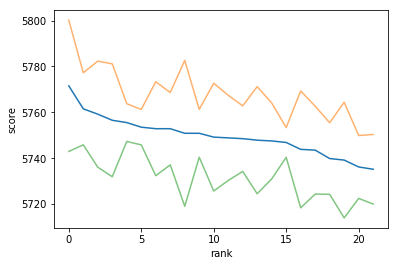

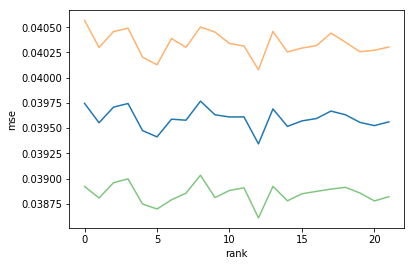

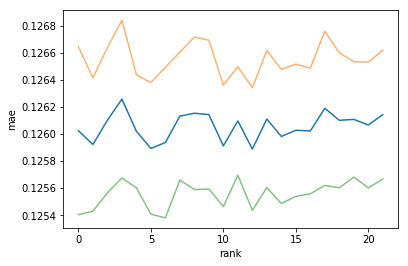

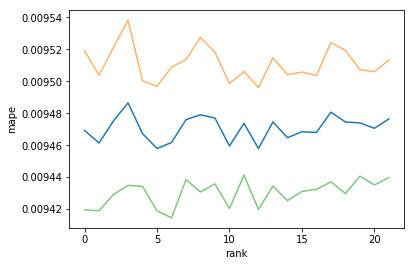

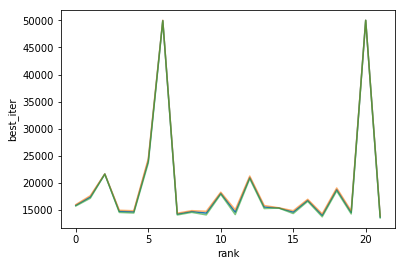

In [85]:
for m in metrics:
    sq = df_gsearch_results[m]
    sq_std = df_gsearch_results[m+'_std']
    plt.plot(sq)
    plt.plot(sq + sq_std, alpha=0.6)
    plt.plot(sq - sq_std, alpha=0.6)
    plt.xlabel('rank'); plt.ylabel(m); plt.show()

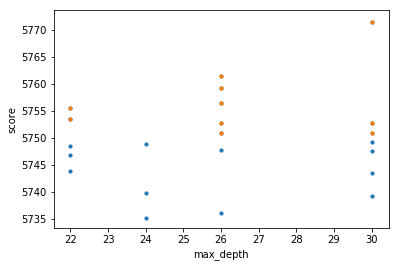

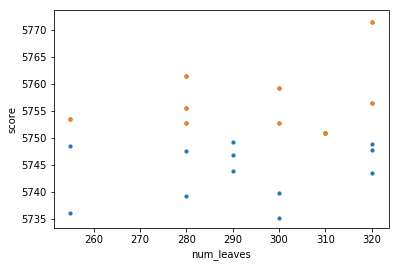

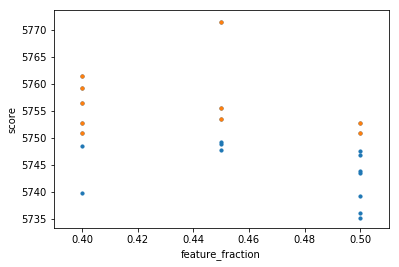

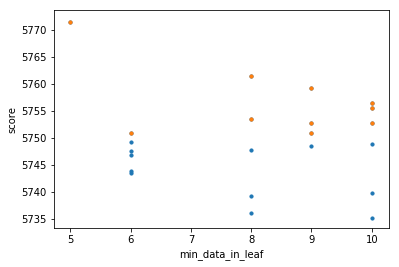

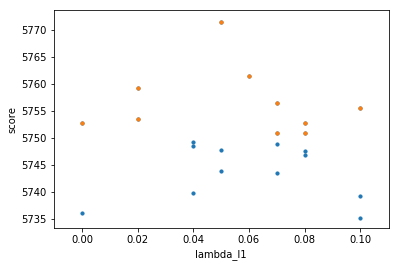

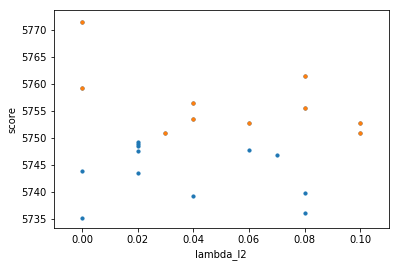

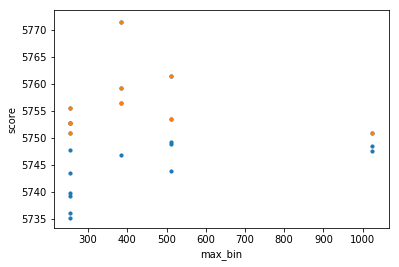

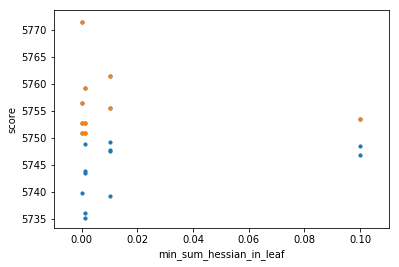

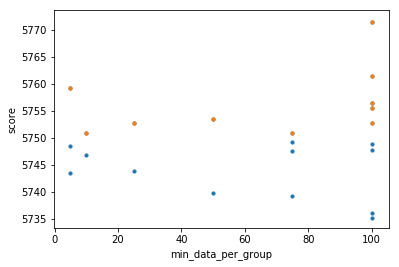

In [50]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=10)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=10)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

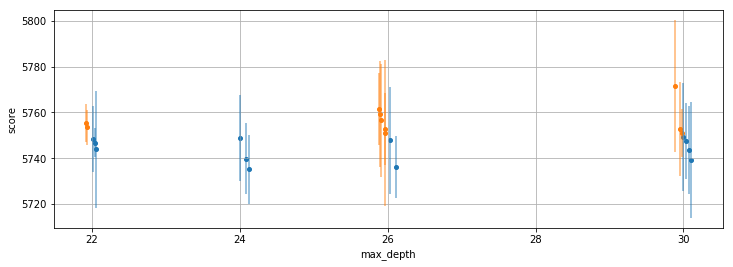

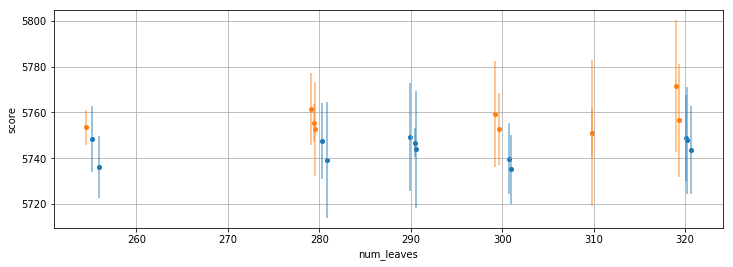

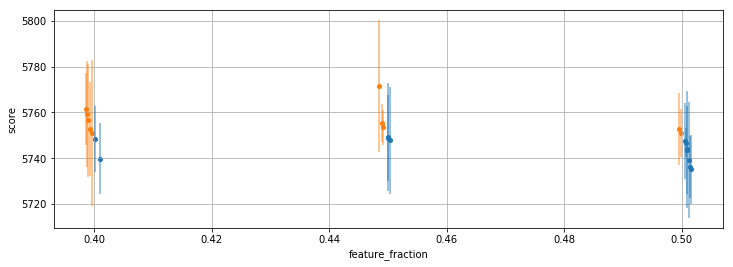

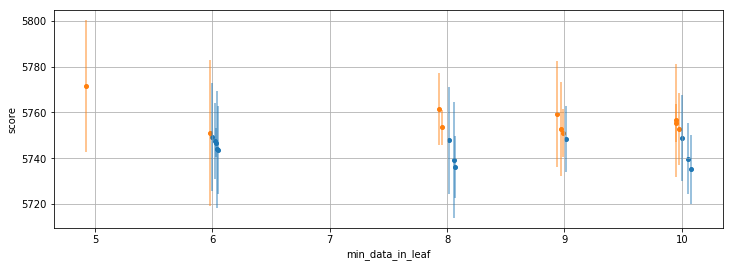

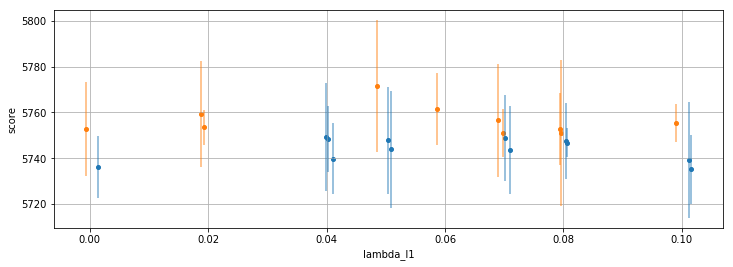

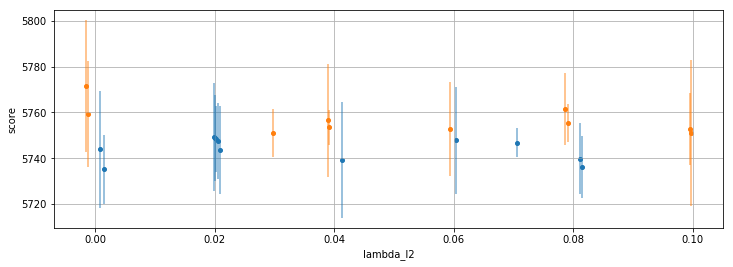

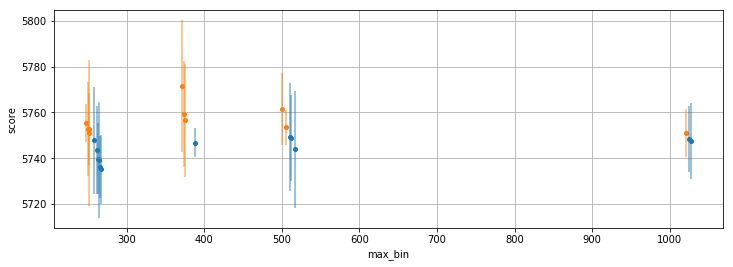

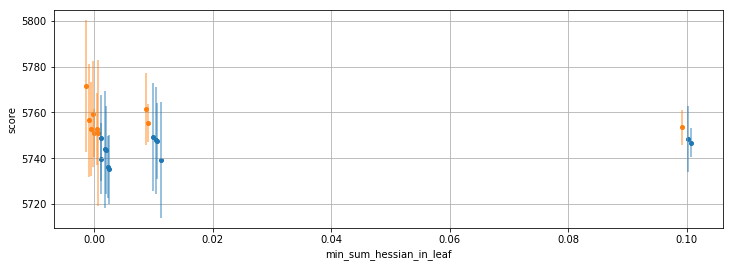

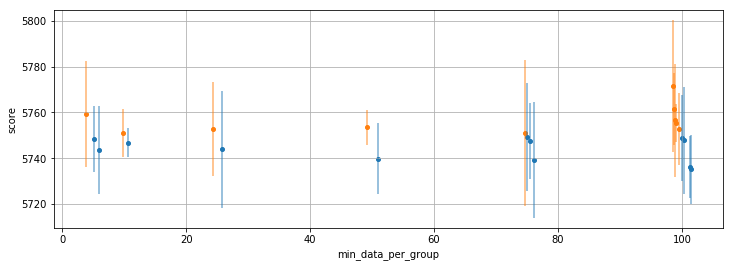

In [84]:
for p in params_gsearch.keys():
    plt.figure(figsize=(12, 4))
    x_sq = df_gsearch_results[p]
    x_shift = (x_sq.max() - x_sq.min())/3/len(x_sq)
    x_sq = x_sq + np.linspace(-x_shift, x_shift, len(x_sq), endpoint=True)
    plt.errorbar(x_sq[10:], df_gsearch_results['score'][10:], 
                 yerr=df_gsearch_results['score_std'][10:], linestyle="None", alpha=0.6)
    plt.errorbar(x_sq[:10], df_gsearch_results['score'][:10], 
                 yerr=df_gsearch_results['score_std'][:10], linestyle="None", alpha=0.6)
    plt.scatter(x_sq[10:], df_gsearch_results['score'][10:], s=16)
    plt.scatter(x_sq[:10], df_gsearch_results['score'][:10], s=16)
    plt.xlabel(p); plt.ylabel('score'); plt.grid(); plt.show()

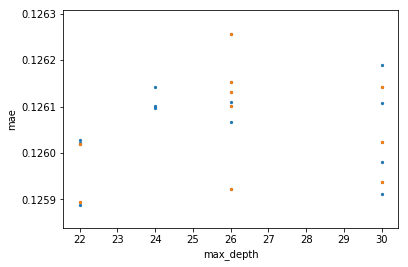

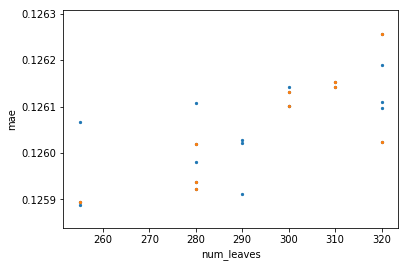

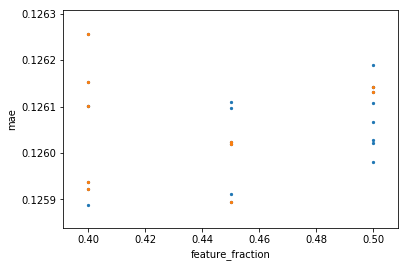

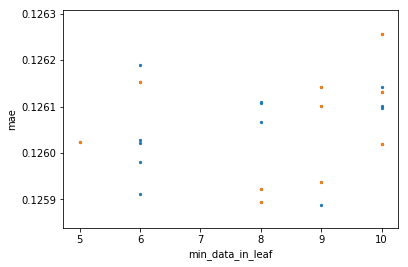

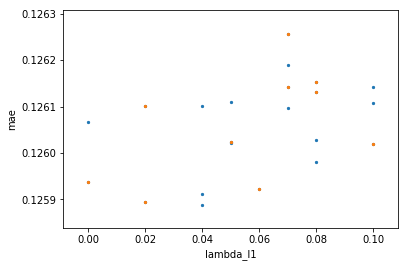

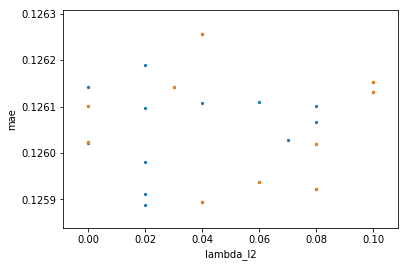

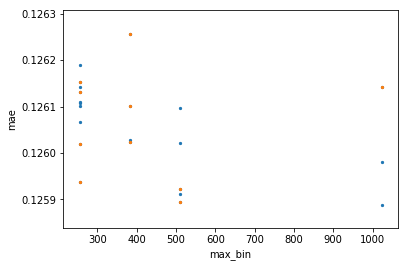

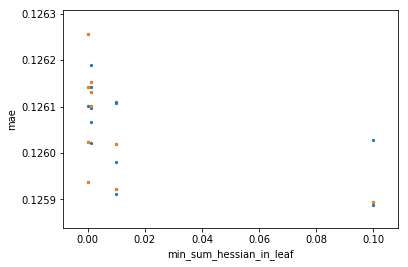

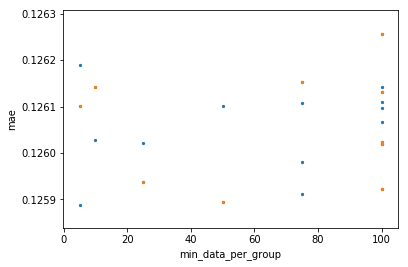

In [42]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=5)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=5)
    plt.ylim(df_gsearch_results['mae'].min()-0.00005, df_gsearch_results['mae'].max()+0.00005)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

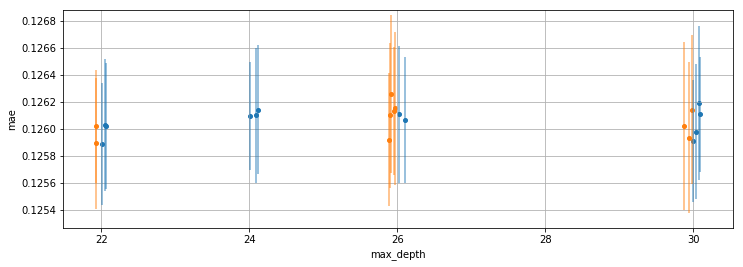

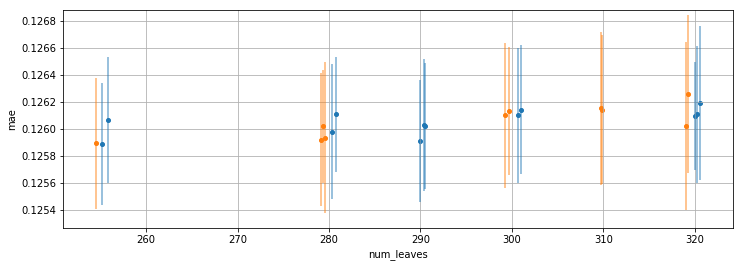

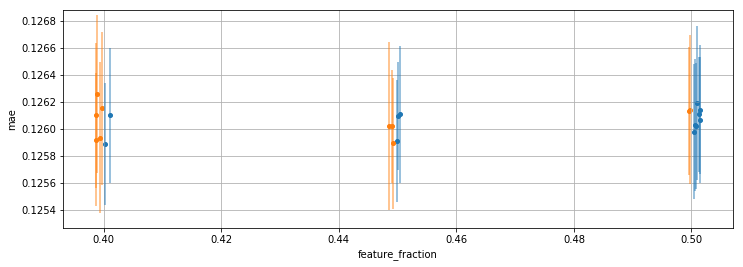

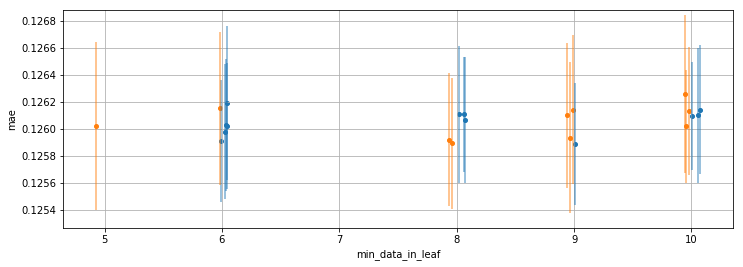

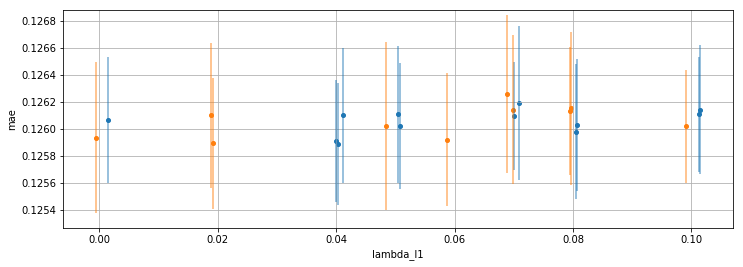

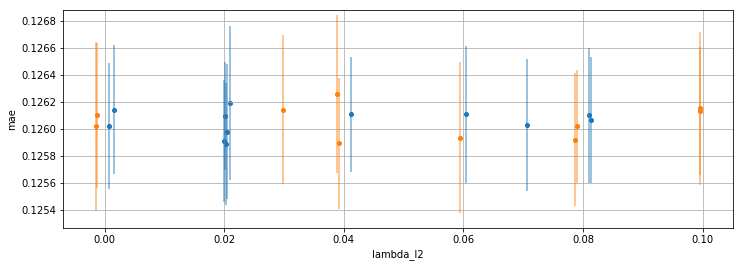

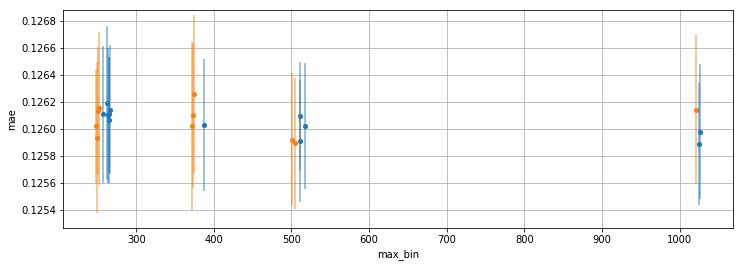

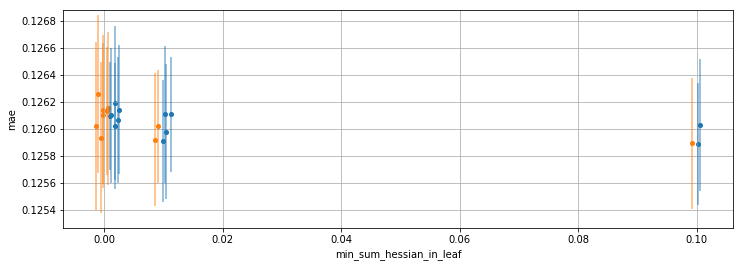

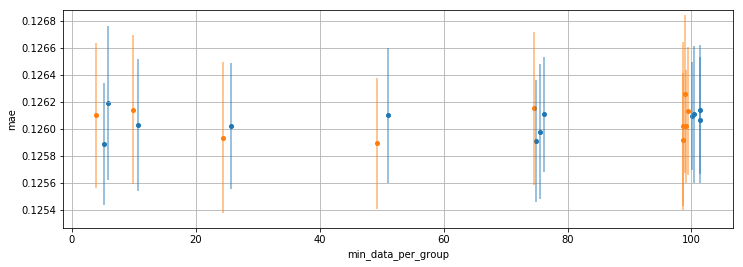

In [88]:
for p in params_gsearch.keys():
    plt.figure(figsize=(12, 4))
    x_sq = df_gsearch_results[p]
    x_shift = (x_sq.max() - x_sq.min())/3/len(x_sq)
    x_sq = x_sq + np.linspace(-x_shift, x_shift, len(x_sq), endpoint=True)
    plt.errorbar(x_sq[10:], df_gsearch_results['mae'][10:], 
                 yerr=df_gsearch_results['mae_std'][10:], linestyle="None", alpha=0.6)
    plt.errorbar(x_sq[:10], df_gsearch_results['mae'][:10], 
                 yerr=df_gsearch_results['mae_std'][:10], linestyle="None", alpha=0.6)
    plt.scatter(x_sq[10:], df_gsearch_results['mae'][10:], s=16)
    plt.scatter(x_sq[:10], df_gsearch_results['mae'][:10], s=16)
    plt.ylim(df_gsearch_results['mae'].min()-df_gsearch_results['mae_std'].max(), 
             df_gsearch_results['mae'].max()+df_gsearch_results['mae_std'].max())
    plt.xlabel(p); plt.ylabel('mae'); plt.grid(); plt.show()

In [43]:
df_gsearch_results.columns

Index(['max_depth', 'num_leaves', 'feature_fraction', 'min_data_in_leaf',
       'lambda_l1', 'lambda_l2', 'max_bin', 'min_sum_hessian_in_leaf',
       'min_data_per_group', 'score', 'mse', 'mae', 'mape', 'best_iter',
       'score_std', 'mse_std', 'mae_std', 'mape_std', 'best_iter_std'],
      dtype='object')

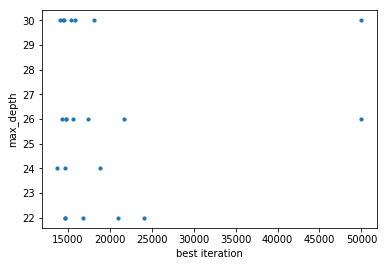

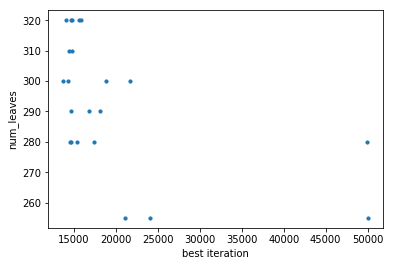

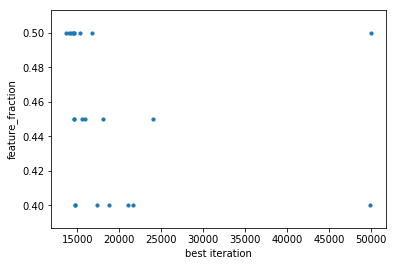

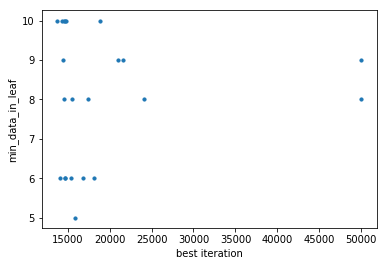

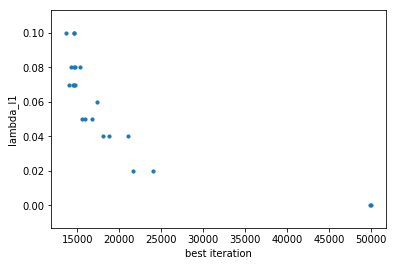

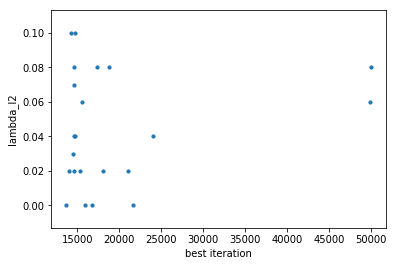

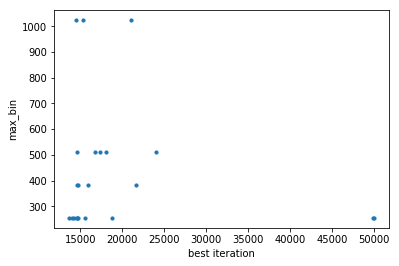

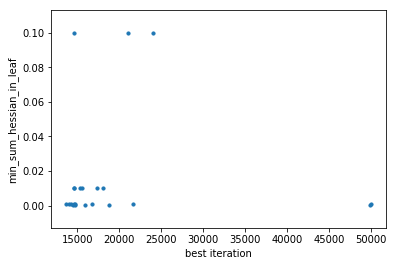

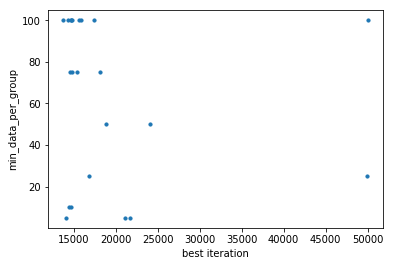

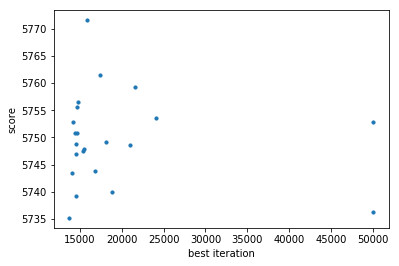

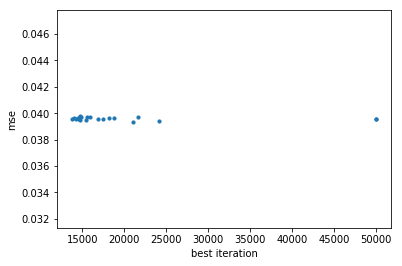

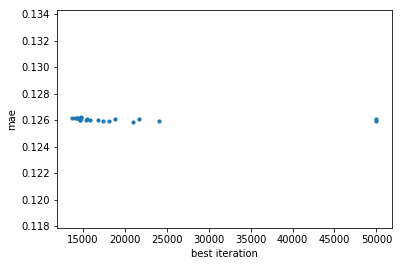

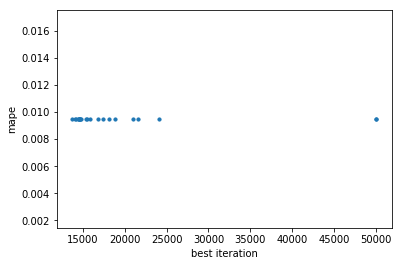

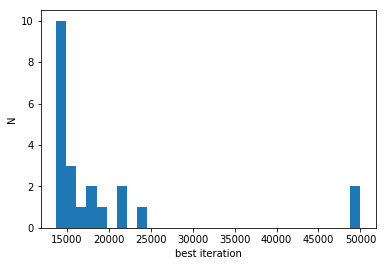

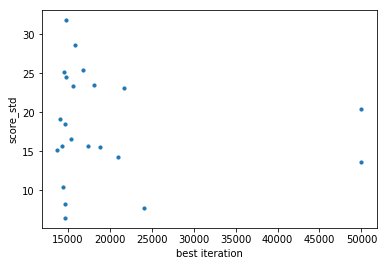

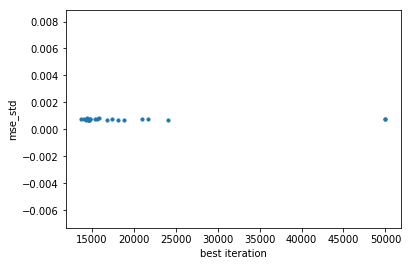

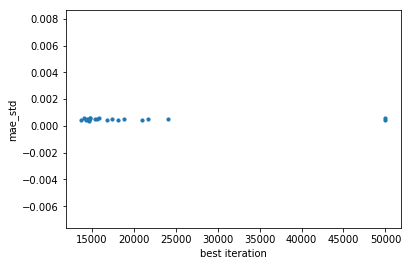

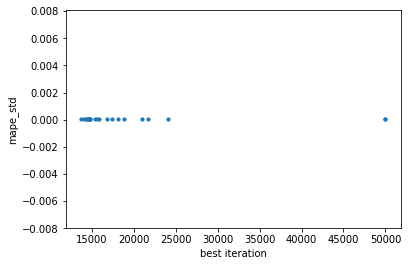

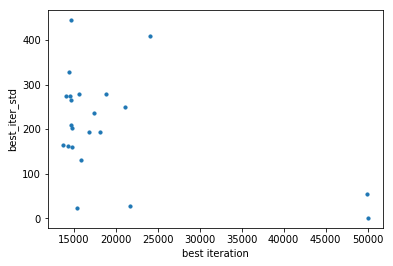

In [49]:
# best iteration
for c in df_gsearch_results.columns:
    if c != 'best_iter':
        plt.scatter(df_gsearch_results['best_iter'], df_gsearch_results[c], s=10)
        plt.ylabel(c)
    else:
        plt.hist(df_gsearch_results['best_iter'], bins=30)
        plt.ylabel('N')        
    plt.xlabel('best iteration')
    plt.show()

### Feature importance

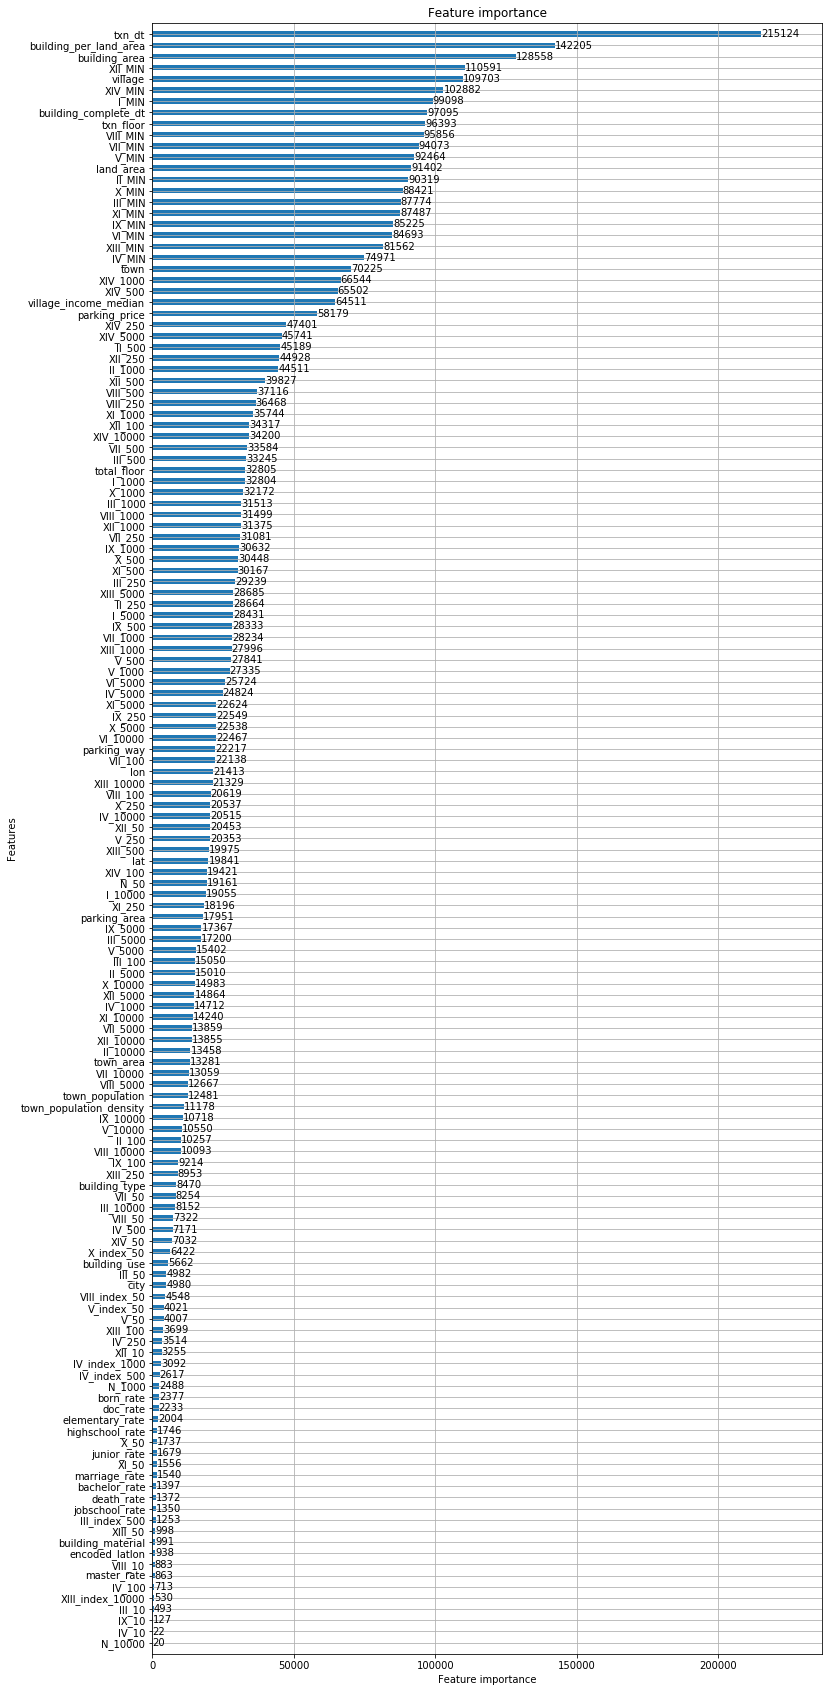

In [89]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

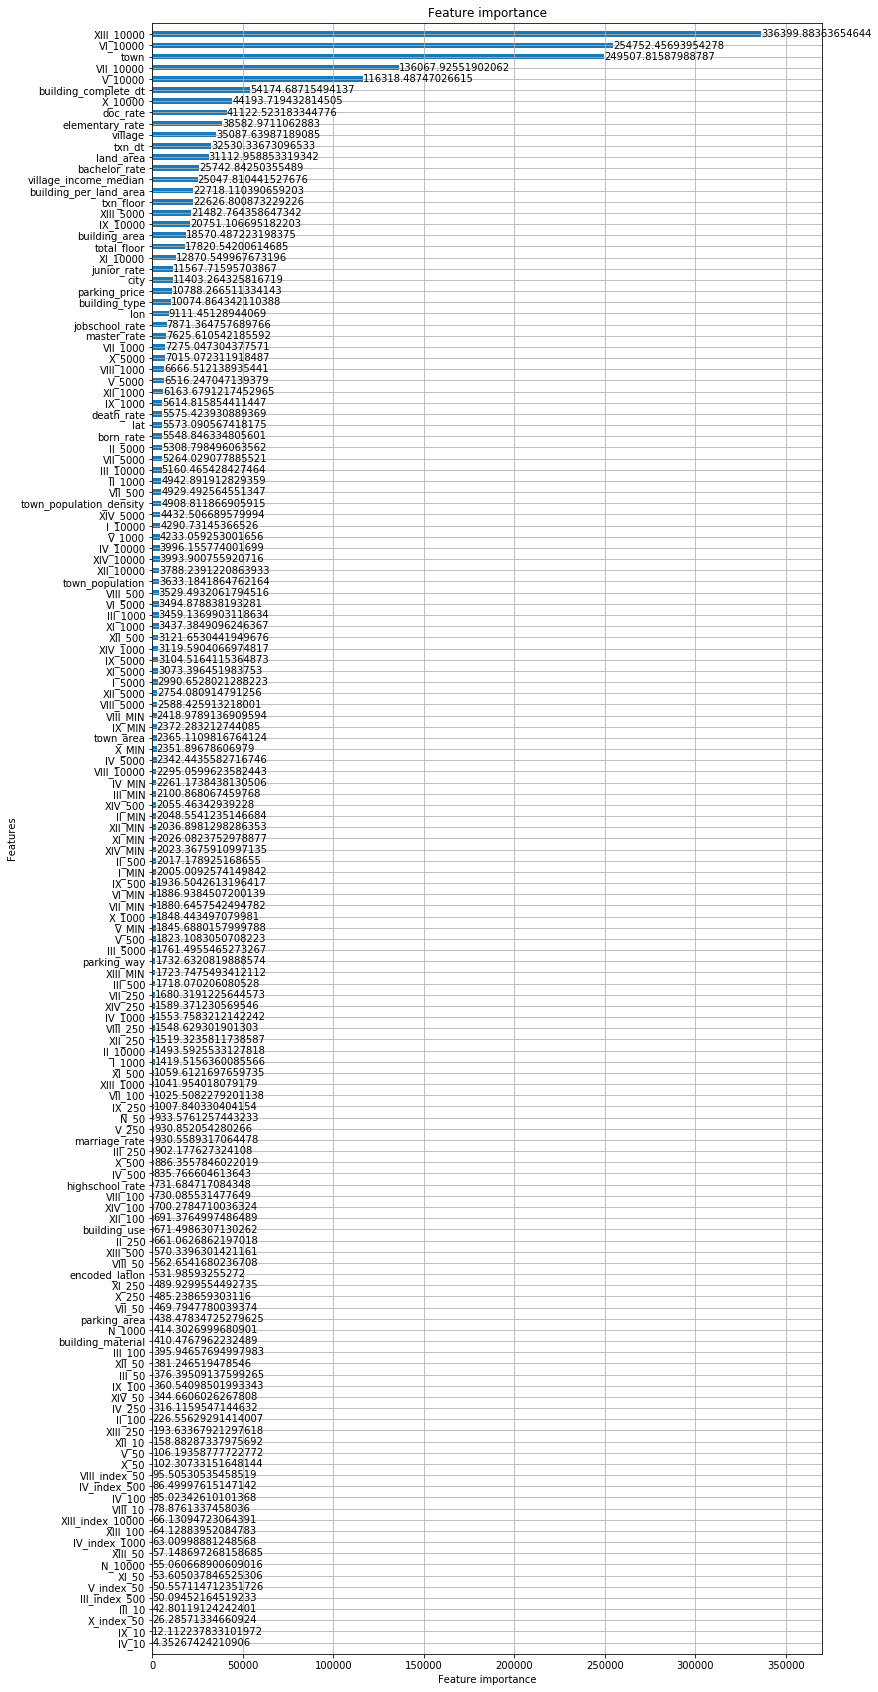

In [90]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()